In [15]:
import os 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# Set up working directory - adjust this to where the repo is stored locally
%cd '/Users/patmccornack/Documents/ucsb_fog_project/_repositories/sci-fog-analysis'

/Users/patmccornack/Documents/ucsb_fog_project/_repositories/sci-fog-analysis


# About

__Author:__ Pat McCornack

__Date:__ December 2024

__Description:__  
This notebook preprocesses the data and does basic qc checks. This includes subsetting the variables, renaming the variables to a standard format, and taking the action specified in the finding summary. 

__Findings Summary:__  
A small number of fog values are missing from the first two days of the dataset, these were dropped. 3 observations had relative humidity values of 0. Given that this is extremely unlikely at the site, these were dropped. 

__Outputs:__  
Cleaned data is output to `./data/02-clean/sci-pozo-smo2-clean-2021-2023.csv`. 

In [16]:
def subset_summer(df):
    """
    Subset data to summer months (May-Sept). This is done because summer is the ecologically relevant period for fog. 

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe to subset.
    
    Returns
    -------
    pandas.DataFrame
        Dataframe subset to May 01 - September 30. 
    """
    df.set_index('time (PST)', inplace=True)
    df = df[df.index.month.isin([5,6,7,8,9])]
    df.reset_index(inplace=True)

    return df

## Data QC 

In [17]:
# Specify parameters
summer_subset = False  # Subset to the summer months?

In [18]:
#### Specify Arguments ###
# Source data paths
src_dir = './data/01-raw/met-station'
src_fname = 'sci-pozo-smo2-2021-2023.csv'
src_fpath = os.path.join(src_dir, src_fname)

# Out paths
outdir = './data/02-clean/'
out_fname = 'sci-pozo-smo2-clean-2021-2023.csv'
out_fname_summer = 'sci-pozo-smo2-summer-clean-2021-2023.csv'

# Define variables
var_dict = {
    'time (PST)' : 'time',
    'fog' :'fog-harp-ml',
    'air temperature (C)' :'air-temperature-average-degc',
    'relative humidity (%)' :'relative-humidity-minimum-rh-min-pct',
    'wind speed (m/s)' : 'wind-speed-wind-vector-cells-ws-ms-u-wvt-ms',
    'wind gust (m/s)' : 'wind-speed-maximum-max-ws-ms-max-ms',
    'wind direction (deg)' : 'air-temperature-wind-vector-cells-wind-dir-du-wvt-deg',
    'rain (mm)' : 'rainfall-sum-rain-mm-tot-mm',
    'solar radiation (kwm2)' :'solar-radiation-average-slr-flux-k-w-avg-kwm-2',
    'atm pressure (mb)' : 'barometric-pressure-average-bp-mbar-avg-mb',
    'leaf wetness (mv)' : 'leaf-wetness-average-l-wm-v-avg-mv'
}

# Fog tip value
fog_tip_v = 3.78

In [19]:
#### Read in and prepare data ####
df = pd.read_csv(src_fpath)

# Subset and rename columns
df = df[list(var_dict.values())]
df.columns = list(var_dict.keys())
df['time (PST)'] = pd.to_datetime(df['time (PST)'])

# Create fog tip var
df['fog tips'] = df['fog'] / fog_tip_v

# Subset to summer months
if summer_subset == True:
    df = subset_summer(df)

### Missing Values
Observations:
1. Pozo is missing a small number of values at the start of the dataset, but not enough to cause concern.

Actions: 
1. Drop the missing observations. 

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74301 entries, 0 to 74300
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   time (PST)              74301 non-null  datetime64[ns]
 1   fog                     74094 non-null  float64       
 2   air temperature (C)     74301 non-null  float64       
 3   relative humidity (%)   74301 non-null  float64       
 4   wind speed (m/s)        74301 non-null  float64       
 5   wind gust (m/s)         74301 non-null  float64       
 6   wind direction (deg)    74301 non-null  float64       
 7   rain (mm)               74301 non-null  float64       
 8   solar radiation (kwm2)  74301 non-null  float64       
 9   atm pressure (mb)       74301 non-null  float64       
 10  leaf wetness (mv)       74301 non-null  float64       
 11  fog tips                74094 non-null  float64       
dtypes: datetime64[ns](1), float64(11)
memory usage

In [21]:
# When are values missing? 
missing = df.loc[df.isna().any(axis=1)]
pd.to_datetime(missing['time (PST)']).describe()

count                              207
mean     2021-08-07 17:10:26.086956544
min                2021-08-07 00:00:00
25%                2021-08-07 08:35:00
50%                2021-08-07 17:10:00
75%                2021-08-08 01:45:00
max                2021-08-08 10:50:00
Name: time (PST), dtype: object

In [22]:
# Drop missing observations
df = df.dropna(subset=['fog'])

### Univariate Distributions

Check boxplots of each variable to assess data quality. There's no major issues that are immediately apparent.  

Observations:
1. Relative humidity is typically high at the site. 
2. Wind typically comes from the northwest. 
3. Most fog observations are 0 - this skews the distribution.
4. There's an RH outlier of 0, this seems implausible at the site. 

Actions
1. Check observation where RH = 0
2. Look closer at the distribution of the fog values

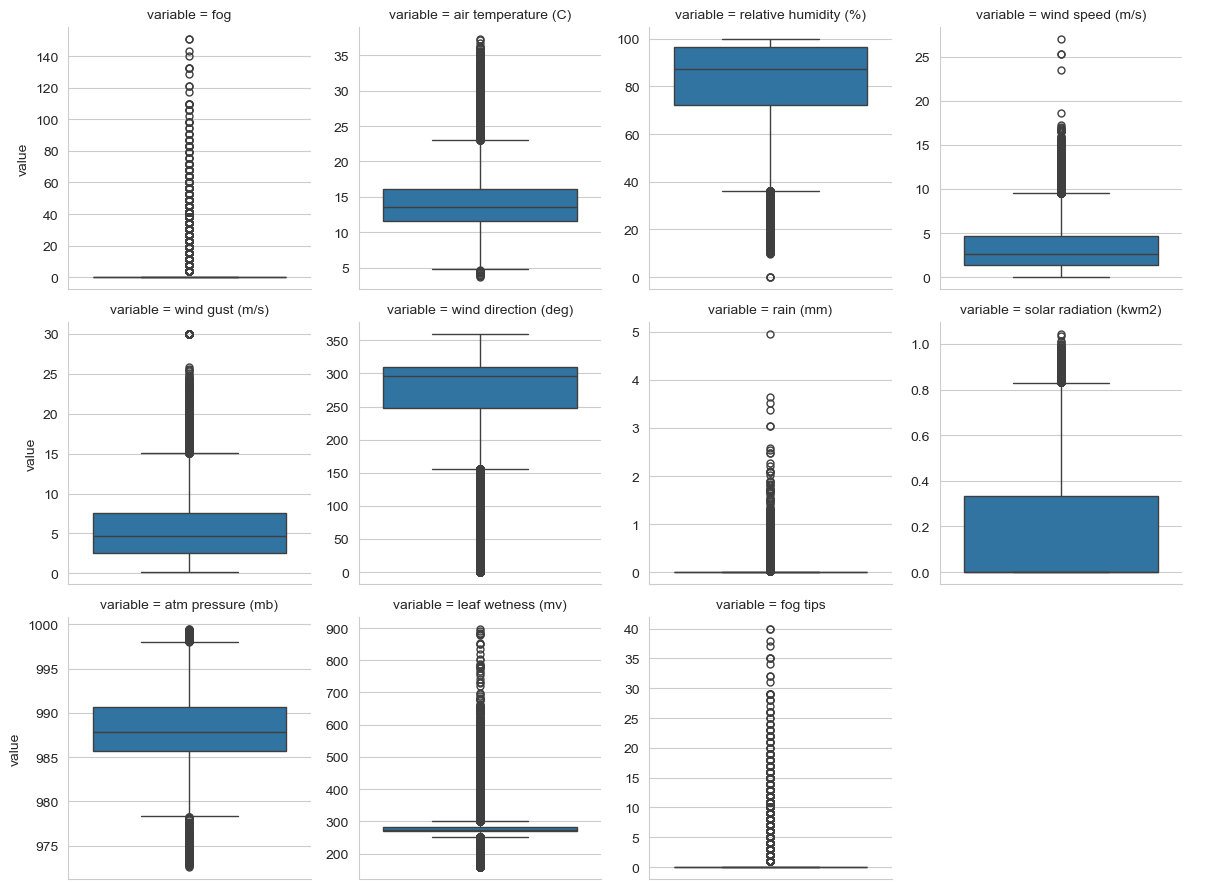

In [23]:
#### Quick plot of distributions ####
# Create long form data
value_col = df.columns.drop(['time (PST)']).tolist()
df_long = pd.melt(df, id_vars=['time (PST)'], value_vars=value_col)

# Plot boxplots
sns.catplot(data=df_long, kind='box', col='variable', y='value',
            sharey=False, height=3, col_wrap=4)
plt.show()


In [24]:
#### Chekc the actual values ####
df.describe()

,time (PST),fog,air temperature (C),relative humidity (%),wind speed (m/s),wind gust (m/s),wind direction (deg),rain (mm),solar radiation (kwm2),atm pressure (mb),leaf wetness (mv),fog tips
count,74094,74094.000000,74094.000000,74094.000000,74094.000000,74094.000000,74094.000000,74094.000000,74094.000000,74094.000000,74094.00000,74094.000000
mean,2022-04-22 17:25:00,1.141235,14.316709,79.440746,3.263713,5.533720,262.890798,0.005730,0.182539,988.169150,284.30268,0.301914
min,2021-08-08 11:00:00,0.000000,3.702000,0.000000,0.008000,0.170000,0.018000,0.000000,0.000000,972.562200,158.10000,0.000000
25%,2021-12-15 02:12:30,0.000000,11.590000,72.300000,1.347000,2.600000,247.900000,0.000000,0.000000,985.642825,270.30000,0.000000
50%,2022-04-22 17:25:00,0.000000,13.570000,87.200000,2.648000,4.670000,296.300000,0.000000,0.002000,987.808150,274.40000,0.000000
75%,2022-08-29 08:37:30,0.000000,16.190000,96.500000,4.638000,7.600000,309.100000,0.000000,0.332000,990.613900,282.60000,0.000000
max,2023-01-04 23:50:00,151.200000,37.320000,100.000000,27.030000,30.000000,360.000000,4.964000,1.045000,999.526600,898.00000,40.000000
std,NaN,5.409387,4.053685,22.662192,2.471969,3.918292,80.085173,0.070859,0.266610,3.699599,41.43103,1.431055


### Check RH Outlier
It's extremely unlikely that the relative humidity is at 0% at this site, especially at such low temperatures.

Actions:
1. Remove the outliers where RH = 0.

In [25]:
#### Check outlier ####
drop_ind = df.loc[df['relative humidity (%)'] == 0].index
df.loc[drop_ind]

,time (PST),fog,air temperature (C),relative humidity (%),wind speed (m/s),wind gust (m/s),wind direction (deg),rain (mm),solar radiation (kwm2),atm pressure (mb),leaf wetness (mv),fog tips
5029,2021-09-10 22:40:00,15.12,14.15,0.0,4.918,7.56,317.0,0.000,0.0,987.5655,300.4,4.0
9802,2021-10-14 02:10:00,0.00,11.23,0.0,2.525,3.52,317.7,0.000,0.0,986.6811,316.2,0.0
44501,2022-06-12 01:20:00,3.78,13.11,0.0,0.313,0.70,192.8,0.017,0.0,983.5972,351.1,1.0


In [26]:
#### Drop observations where RH = 0 ####
df.drop(drop_ind, inplace=True)
df[['relative humidity (%)']].describe()

,relative humidity (%)
count,74091.000000
mean,79.443962
std,22.657012
min,9.800000
25%,72.300000
50%,87.200000
75%,96.500000
max,100.000000


<Axes: xlabel='condition', ylabel='leaf wetness (mv)'>

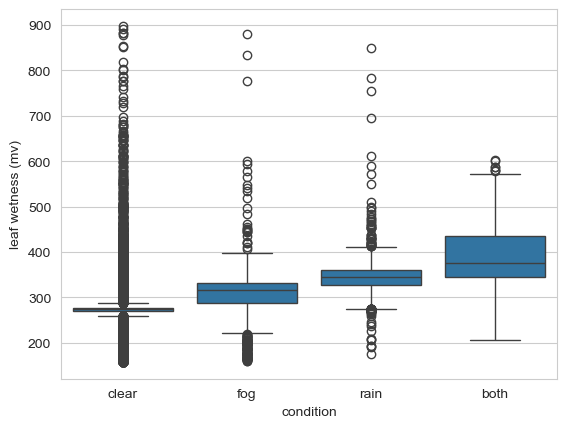

In [27]:
def label_condition(df):
    df['condition'] = 'clear'
    for index, row in df.iterrows():
        condition='clear'
        if row['fog tips'] > 0:
            df.loc[index, 'condition'] = 'fog'

        if row['rain (mm)'] > 0:
            df.loc[index, 'condition'] = 'rain'
        
        if (row['rain (mm)'] > 0) & (row['fog tips'] > 0):
            df.loc[index, 'condition'] = 'both'
    
    return df
tmp = df[['fog tips', 'rain (mm)', 'leaf wetness (mv)']].copy()
tmp = label_condition(tmp)

sns.boxplot(data=tmp,
            x='condition',
            y='leaf wetness (mv)')

### Fog Check
Given the focus of further analysis on fog at the site, further check the distribution of fog.

Observations:
1. Nothing of note, the distribution is as expected. 


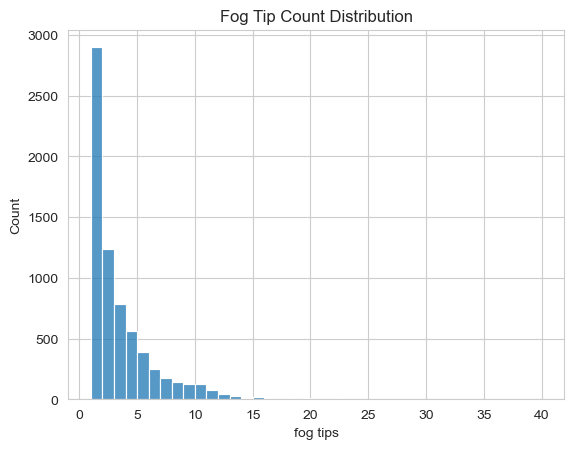

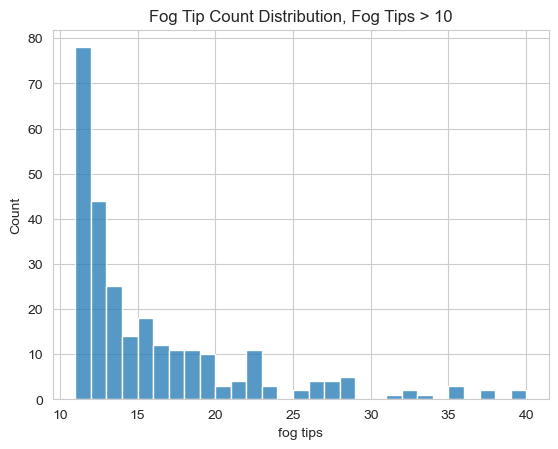

In [28]:
#### Check Distribution of Fog Values ####
sns.histplot(df['fog tips'].loc[df['fog tips']>0],
             binwidth=1)
plt.title('Fog Tip Count Distribution')
plt.show()

# Check right tail of distribution
sns.histplot(df['fog tips'].loc[df['fog tips']>10],
             binwidth=1)
plt.title('Fog Tip Count Distribution, Fog Tips > 10')
plt.show()

### Save out cleaned data

In [29]:
#### Save out cleaned data ####

if summer_subset == True:
    out_fpath = os.path.join(outdir, out_fname_summer)
    df.to_csv(out_fpath)

else:
    out_fpath = os.path.join(outdir, out_fname)
    df.to_csv(out_fpath)

print(out_fpath)

./data/02-clean/sci-pozo-smo2-clean-2021-2023.csv
